In [1]:
import qiskit
import numpy as np
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.nqubit, qtm.fubini_study, qtm.encoding
import importlib
importlib.reload(qtm.base)
importlib.reload(qtm.constant)
importlib.reload(qtm.onequbit)
importlib.reload(qtm.nqubit)
importlib.reload(qtm.fubini_study)

<module 'qtm.fubini_study' from '..\\qtm\\fubini_study.py'>

20/12/2021

In this notebook I will conduct the experiments about tomography.

With $U_{gen} = $ Haar random

And $U_{target} = W + ZXZ, W = W_{chain}, W_{all to all}, W_{alternating}$

### 1. W_{chain}

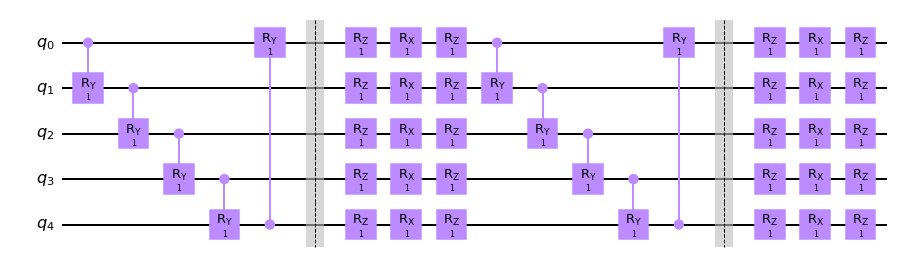

In [5]:
num_qubits = 5
num_layers = 2
thetas = np.ones(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')

qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')

In [ ]:
num_qubits = 3
num_layers = 1
thetas = np.ones(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []

# qc = encoder.qcircuit
# qc = qtm.nqubit.create_Wchainchecker_haar(qc, thetas, num_layers)

for i in range(0, 400):
    if i % 20 == 0:
        print('W_chain: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Wchainchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Wchainchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


In [45]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_wchain_/" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

Writting ... 3


C:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


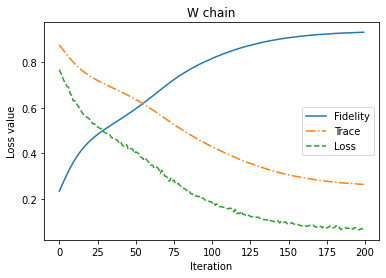

In [ ]:
from matplotlib import pyplot as plt
plt.plot(fidelities, label='Fidelity', linestyle = '-')
plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 

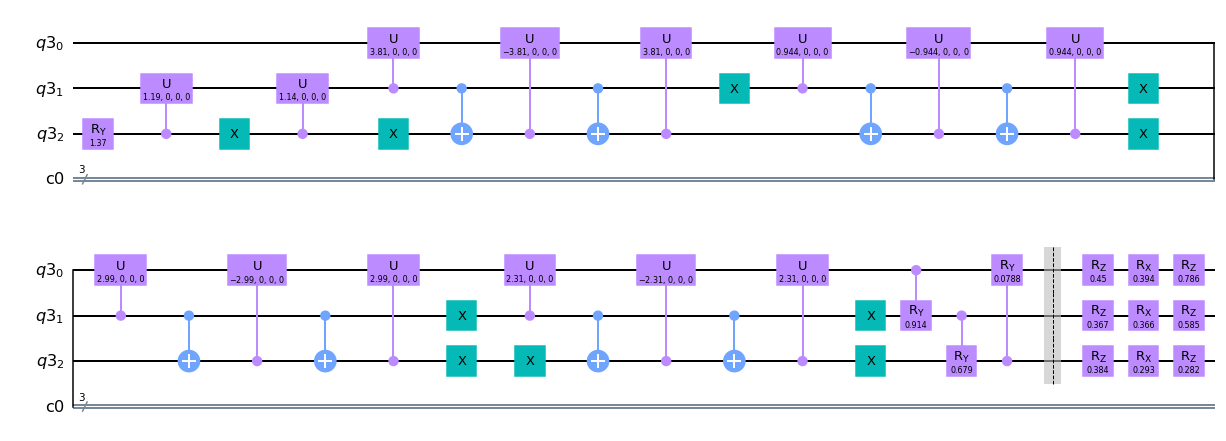

In [5]:
num_qubits = 3
num_layers = 1
thetas = np.random.random(num_layers*num_qubits*4)
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = encoder.qcircuit
qc = qtm.nqubit.create_Wchain_layerd_state(qc, thetas, num_layers=num_layers)
qc.add_register(qiskit.ClassicalRegister(encoder.num_qubits))
qc.draw('mpl')

### 2. W alternating

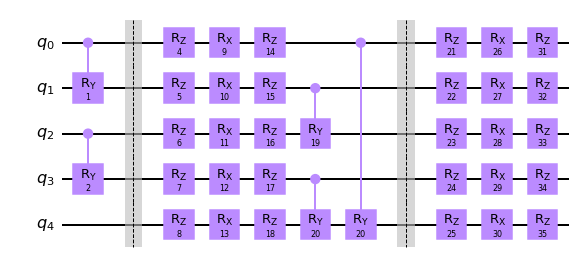

In [6]:
num_qubits = 5
num_layers = 2
n_alternating = 0
for i in range(0, num_layers + 1):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walternating_layerd_state(qc,
                                                 thetas,
                                                 num_layers=num_layers)
qc.draw('mpl')


In [125]:
num_qubits = 3
num_layers = 1
n_alternating = 0
for i in range(0, num_layers + 1):
    n_alternating += qtm.nqubit.calculate_n_walternating(i, num_qubits)
thetas = np.ones(n_alternating + 3 * num_layers * num_qubits)

for i in range(0, len(thetas)):
    thetas[i] += i

psi = 2 * np.random.rand(2**num_qubits) - 1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 400):
    if i % 20 == 0:
        print('W_alternating: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walternatingchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walternatingchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


W_alternating:  0
W_alternating:  20
W_alternating:  40
W_alternating:  60
W_alternating:  80
W_alternating:  100
W_alternating:  120
W_alternating:  140
W_alternating:  160
W_alternating:  180


In [127]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walternating_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))

np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walternating_/" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

Writting ... 3


C:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


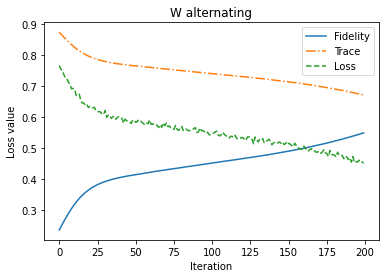

In [128]:
from matplotlib import pyplot as plt
plt.plot(fidelities, label='Fidelity', linestyle = '-')
plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W alternating')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 


### 3. W all to all

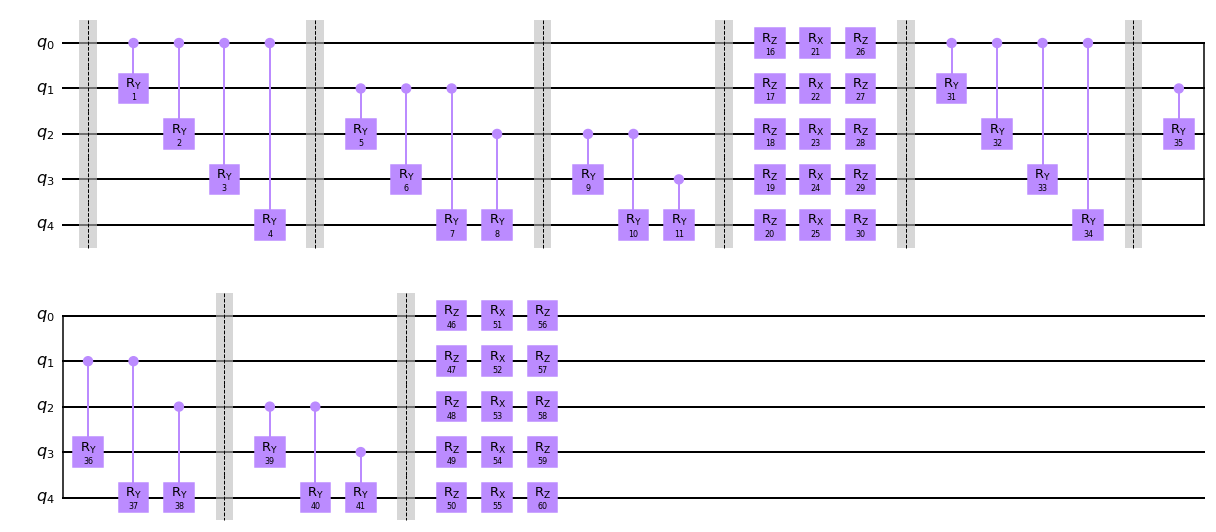

In [7]:
num_qubits = 5
num_layers = 2
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')
qc = qiskit.QuantumCircuit(num_qubits)
qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers=num_layers)
qc.draw('mpl')


In [ ]:
num_qubits = 3
num_layers = 1
n_walltoall = qtm.nqubit.calculate_n_walltoall(num_qubits)
thetas = np.ones(num_layers* 3 * num_qubits + num_layers*n_walltoall)
for i in range(0, len(thetas)):
    thetas[i] += i
psi = 2*np.random.rand(2**num_qubits)-1
psi = psi / np.linalg.norm(psi)
encoder = qtm.encoding.Encoding(psi, 'amplitude_encoding')


loss_values = []
thetass = []
for i in range(0, 200):
    if i % 20 == 0:
        print('W_chain: ', i)
    qc = encoder.qcircuit
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.nqubit.create_Walltoallchecker_haar,
        thetas, r = 1/2, s = np.pi/2, num_layers = num_layers)
    thetas -= qtm.constant.learning_rate*(grad_loss) 
    thetass.append(thetas.copy())
    qc_copy = qtm.nqubit.create_Walltoallchecker_haar(qc.copy(), thetas, num_layers)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values.append(loss)


In [53]:
traces = []
fidelities = []

for thetas in thetass:
    # Get |psi> = U_gen|000...>
    qc1 = encoder.qcircuit
    psi = qiskit.quantum_info.Statevector.from_instruction(qc1)
    # Get |psi~> = U_target|000...>
    qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
    qc = qtm.nqubit.create_Walltoall_layerd_state(qc, thetas, num_layers = num_layers).inverse()
    psi_hat = qiskit.quantum_info.Statevector.from_instruction(qc)
    # Calculate the metrics
    trace, fidelity = qtm.base.get_metrics(psi, psi_hat)
    traces.append(trace)
    fidelities.append(fidelity)
print('Writting ... ' + str(num_qubits))


np.savetxt("../../experiments/tomography_walltoall_/" + str(num_layers) + '/' + str(num_qubits) + "/loss_values.csv", loss_values, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_/" + str(num_layers) + '/' + str(num_qubits) + "/thetass.csv", thetass, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_/" + str(num_layers) + '/' + str(num_qubits) + "/traces.csv", traces, delimiter=",")
np.savetxt("../../experiments/tomography_walltoall_/" + str(num_layers) + '/' + str(num_qubits) + "/fidelities.csv", fidelities, delimiter=",")

Writting ... 3


C:\Users\haime\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


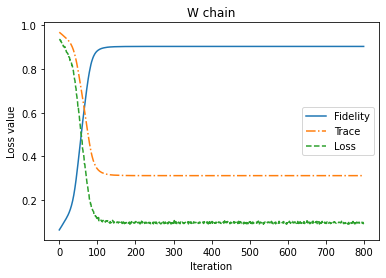

0.09060000000000001


In [56]:
from matplotlib import pyplot as plt
plt.plot(fidelities, label='Fidelity', linestyle = '-')
plt.plot(traces, label='Trace', linestyle = '-.')
plt.plot(loss_values, label='Loss', linestyle = '--')
plt.title('W chain')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.show() 
